In [2]:
from dataclasses import dataclass
import numpy as np
from typing import Union,Type
from numpy import ndarray

# baseline on low earth orbit

In [3]:
radius = 2
sim_duration = 10
num_steps = 10**3
t = np.linspace(0, sim_duration, num_steps)
ts = t[1]-t[0]
center = [0,0,0]
chief = np.zeros((*t.shape,3))
deputy = np.zeros((2, *chief.shape))
star_sph = [np.pi/3.0, np.pi/2.0]
star = np.array([np.sin(star_sph[0])*np.cos(star_sph[1]),
                 np.sin(star_sph[0])*np.sin(star_sph[1]),
                 np.cos(star_sph[0])
               ])

deputy_lvlh = np.zeros((2, *chief.shape))
star_lvlh = np.zeros(chief.shape)

In [4]:
def unit(v):
    return v/np.linalg.norm(v)

@dataclass
class Circle2D:
    radius: float
    center: ndarray
    w: float
    rad_init: float = 0
    phase: Union[ndarray,None] = None
    pos: Union[ndarray,None] = None

    def vel(self):
        return self.radius*self.w*np.array([-np.sin(self.phase), \
                                             np.cos(self.phase)])

    def lvlh_frame(self):
        rho = np.append(unit(self.pos), 0)
        v = np.append(self.vel(), 0)
        xi = unit(v)
        eta = np.cross(rho, xi)
        return np.vstack((rho, xi, eta))

def lvlh2euclid(frame, x):
    assert(x.shape == (3,))
    return x@frame

def euclid2lvlh(lvlh_frame, x):
    assert(x.shape == (3,))
    return np.linalg.solve(lvlh_frame.T, x).T

def circle_gen(circle, t):
    for ti in t-t[0]:
        phase = circle.rad_init+circle.w*ti
        pos = circle.center + radius*np.array([np.cos(phase), np.sin(phase)])
        circle.phase = phase
        circle.pos = pos
        yield circle

def deputy_diff_lvlh(chief, k4, theta, phi, phase):
    pos_diff = np.array([0, k4, -k4*np.tan(theta)*np.sin(phi-phase)])
    return pos_diff

In [5]:
circle = Circle2D(radius, center[:2], 2*np.pi/sim_duration, 0)
chief_gen = circle_gen(circle, t)

for i, ti in enumerate(t-t[0]):
    traj = next(chief_gen)
    lvlh_frame = traj.lvlh_frame()
    chief[i] = np.append(traj.pos, 0)
    diff = deputy_diff_lvlh(chief, 0.3, *star_sph, traj.phase)
    deputy_lvlh[0][i] = diff
    diff = lvlh2euclid(lvlh_frame, diff)
    deputy[0][i] = chief[i]+diff
    diff = deputy_diff_lvlh(chief, -0.3, *star_sph, traj.phase)
    deputy_lvlh[1][i] = diff
    diff = lvlh2euclid(lvlh_frame, diff)
    deputy[1][i] = chief[i]+diff
    
    star_lvlh[i] = euclid2lvlh(lvlh_frame, star)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['text.usetex'] = True
from matplotlib import colormaps

Text(0.5, 0.92, 'inertia frame')

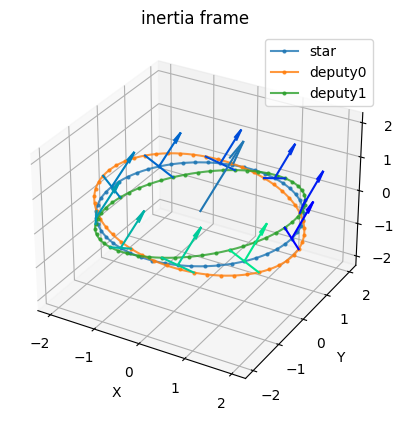

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

lim=radius*1.1
ax.set(xlim3d=(-lim, lim), xlabel='X')
ax.set(ylim3d=(-lim, lim), ylabel='Y')
ax.set(zlim3d=(-lim, lim), zlabel='Z')

markevery = len(t)//50
lines = [ax.plot(*data, 'o-', markevery=markevery, markersize=2)[0] \
         for data in (chief.T, deputy[0].T, deputy[1].T)]
for line in lines:
    line.set_alpha(0.8)
lines[0].set_label('star');
lines[1].set_label('deputy0');
lines[2].set_label('deputy1');
ax.quiver(*center, *radius*star)

connectevery = len(t)//10
cmap_deputy = colormaps['winter']
cmap_star = colormaps['winter']
for i in range(0, len(t), connectevery):
    ci = i/len(t)
    formation = np.array((chief[i], *deputy[:,i]))
    formation = formation[[1,0,2]]
    ax.plot(*formation.T, '-', c=cmap_deputy(ci))
    ax.quiver(*formation[1], *(star), color=cmap_star(ci))
ax.legend()
ax.set_title('inertia frame')

<IPython.core.display.Javascript object>


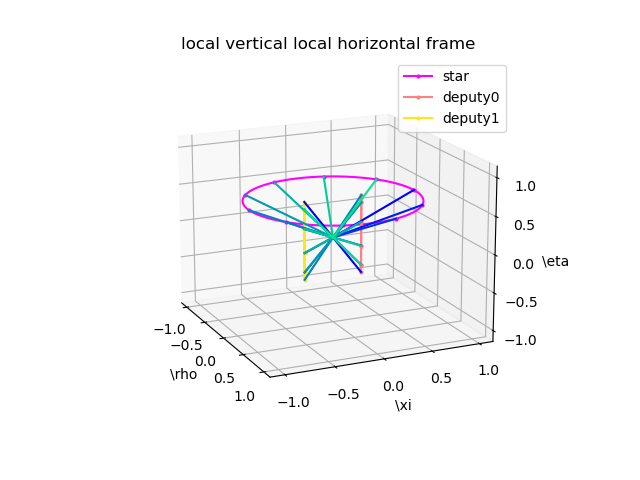

Text(0.5, 0.92, 'local vertical local horizontal frame')

In [6]:
# in lvlh frame
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

lim=1.1
ax.set(xlim3d=(-lim, lim), xlabel=r'\rho')
ax.set(ylim3d=(-lim, lim), ylabel=r'\xi')
ax.set(zlim3d=(-lim, lim), zlabel=r'\eta')

markevery = len(t)//10
cmap = colormaps['spring']
lines = [ax.plot(*data, 'o-', markevery=markevery, markersize=2)[0] \
         for data in (star_lvlh.T,deputy_lvlh[0].T, deputy_lvlh[1].T)]
lines[0].set_label('star');lines[0].set_color(cmap(0))
lines[1].set_label('deputy0');lines[1].set_color(cmap(0.5))
lines[2].set_label('deputy1');lines[2].set_color(cmap(0.9))

connectevery = len(t)//10
cmap_deputy = colormaps['winter']
cmap_star = colormaps['winter']

for i in range(0, len(t), connectevery):
    formation = np.array(([0,0,0], *deputy_lvlh[:,i]))
    formation = formation[[1,0,2]]
    ci = i/len(t)
    ax.plot(*formation.T, '-', c=cmap_deputy(ci))
    tmp = np.array(([0,0,0], star_lvlh[i]))
    ax.plot(*tmp.T, '-', c=cmap_star(ci))
ax.legend()
ax.set_title('local vertical local horizontal frame')

# baseline on ground

<IPython.core.display.Javascript object>


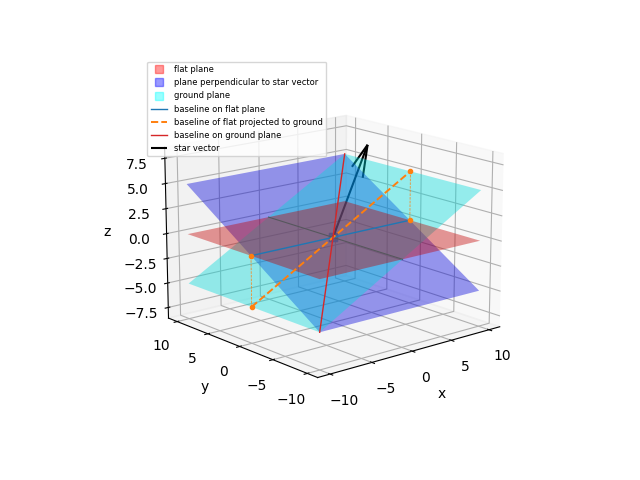

In [67]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

dim = 10
lim=dim*1.1
ax.set(xlim3d=(-lim, lim), xlabel=r'x')
ax.set(ylim3d=(-lim, lim), ylabel=r'y')
ax.set(zlim3d=(-lim, lim), zlabel=r'z')
ax.set_aspect('equal')

X, Y = np.meshgrid([-dim, dim], [-dim, dim])
Z = np.zeros((2, 2))
ax.plot_surface(X, Y, Z, color='red', alpha=.4, linewidth=0)
ax.plot([0],[0],[0],linestyle="none",alpha=.4, c='r', marker = 's', label='flat plane')

angle = .5
X2, Y2 = np.meshgrid([-dim, dim], [-dim, dim])
Z2 = Y2 * angle

ax.plot_surface(X2, Y2, Z2, color='blue', alpha=.4, linewidth=0)
ax.plot([0],[0],[0],linestyle="none",alpha=.4, c='blue', marker = 's', label='plane perpendicular to star vector')
ax.plot([0],[0],[0],linestyle="none",alpha=.4, c='cyan', marker = 's', label='ground plane')
ax.plot([-dim,  dim], [0, 0], [0, 0], linewidth=1, label='baseline on flat plane', zorder=100)
h = ax.plot([-dim,  dim], [0, 0], [-dim*angle, dim*angle], '--', linewidth=1.4, label='baseline of flat projected to ground', zorder=100)
ax.plot([-dim, -dim], [0, 0], [-dim*angle, 0], '.--', color=h[0].get_color(), linewidth=0.5,zorder=100)
ax.plot([dim, dim], [0, 0], [dim*angle, 0], '.--', color=h[0].get_color(), linewidth=0.5,zorder=100)

Z3 = X2 * angle
ax.plot_surface(X2, Y2, Z3, color='cyan', alpha=.4, linewidth=0)

ax.plot([0, 0], [-dim,  dim],[0, 0], linewidth=0.8)

ax.plot([-dim, dim], [-dim,  dim], np.array([-dim, dim])*angle, linewidth=1, label='baseline on ground plane',zorder=100)

# offset


star = [0, -angle*dim, dim]
ax.quiver(0, 0, 0, *star, color='k', zorder=100, label='star vector')
ax.legend(loc=2, prop={'size': 6})